In [1]:
import prediction
import data_importer2

In [3]:
prediction.save_prediction(dataset_address='D:/Library/Datasets/raai-summer-school-2019-CV-test',dataset_size=500)

D:\Programs\anaconda3\envs\tf\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to float32
  .format(dtypeobj_in, dtypeobj_out))
D:\Programs\anaconda3\envs\tf\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
D:\Programs\anaconda3\envs\tf\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


0000_3.
0001_3.
0002_3.
0003_3.
0004_3.
0005_3.
0006_3.
0007_3.
0008_3.
0009_3.
0010_3.
0011_3.
0012_3.
0013_3.
0014_3.
0015_3.
0016_3.
0017_3.
0018_3.
0019_3.
0020_3.
0021_3.
0022_3.
0023_3.
0024_3.
0025_3.
0026_3.
0027_3.
0028_3.
0029_3.
0030_3.
0031_3.
0032_3.
0033_3.
0034_3.
0035_3.
0036_3.
0037_3.
0038_3.
0039_3.
0040_3.
0041_3.
0042_3.
0043_3.
0044_3.
0045_3.
0046_3.
0047_3.
0048_3.
0049_3.
0050_3.
0051_3.
0052_3.
0053_3.
0054_3.
0055_3.
0056_3.
0057_3.
0058_3.
0059_3.
0060_3.
0061_3.
0062_3.
0063_3.
0064_3.
0065_3.
0066_3.
0067_3.
0068_3.
0069_3.
0070_3.
0071_3.
0072_3.
0073_3.
0074_3.
0075_3.
0076_3.
0077_3.
0078_3.
0079_3.
0080_3.
0081_3.
0082_3.
0083_3.
0084_3.
0085_3.
0086_3.
0087_3.
0088_3.
0089_3.
0090_3.
0091_3.
0092_3.
0093_3.
0094_3.
0095_3.
0096_3.
0097_3.
0098_3.
0099_3.
0100.
0100_3.
0101.
0101_3.
0102.
0102_3.
0103.
0103_3.
0104.
0104_3.
0105.
0105_3.
0106.
0106_3.
0107.
0107_3.
0108.
0108_3.
0109.
0109_3.
0110.
0110_3.
0111.
0111_3.
0112.
0112_3.
0113.
0113_3.
0114

In [8]:
import data_importer
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

tf.keras.backend.set_floatx('float32')

layers = tf.keras.layers
losses = tf.keras.losses

from skimage.transform import resize
from skimage.measure import label, regionprops
import matplotlib

import pandas as pd

In [7]:
import model as md

##### importing data

In [4]:
img_shape = (416, 416, 3)

float32 (1, 416, 416, 3)


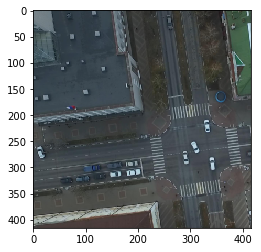

In [9]:
batch_size = 1

CrossRoad_test = data_importer2.CrossRoad('D:/Library/Datasets/raai-summer-school-2019-CV-test',label_type='sparse_segmentation', usage='test',
                                    batch_size=batch_size, repeater=True, shuffle=True, output_shape=img_shape[:2], data_type='float32', ratio=(0, 0)
                                         ,give_reference=True)

preview = iter(CrossRoad_test)
a=next(preview)[0]

plt.imshow(np.float32(a[0]))


print(a.dtype, a.shape)

D:\Programs\anaconda3\envs\tf\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to float32
  .format(dtypeobj_in, dtypeobj_out))
D:\Programs\anaconda3\envs\tf\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
D:\Programs\anaconda3\envs\tf\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
D:\Programs\anaconda3\envs\tf\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


float32 uint8 (1, 416, 416, 3) (1, 416, 416, 1)


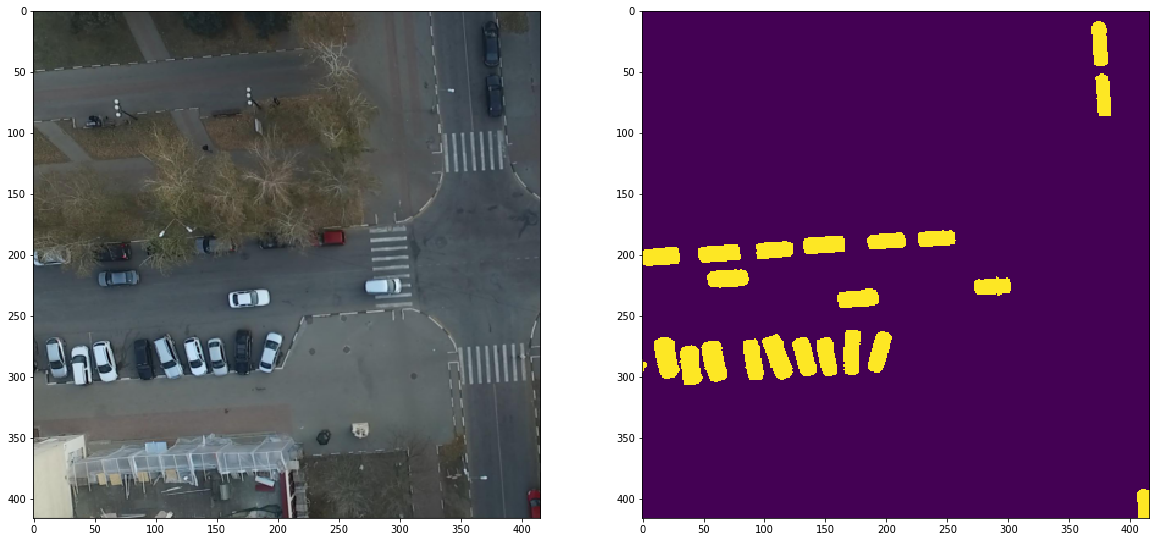

In [8]:
batch_size = 1
CrossRoad_train = data_importer.CrossRoad('D:/Library/Datasets/raai-summer-school-2019-CV-train',label_type='sparse_segmentation', usage='train',
                                    batch_size=batch_size, repeater=True, shuffle=True, output_shape=img_shape[:2], data_type='float32', ratio=(1, 0))
CrossRoad_validation = data_importer.CrossRoad('D:/Library/Datasets/raai-summer-school-2019-CV-train',label_type='sparse_segmentation', usage='validation',
                                    batch_size=batch_size, repeater=True, shuffle=True, output_shape=img_shape[:2], data_type='float32', ratio=(0.8, 0.1))
CrossRoad_test = data_importer.CrossRoad('D:/Library/Datasets/raai-summer-school-2019-CV-train',label_type='sparse_segmentation', usage='test',
                                    batch_size=batch_size, repeater=True, shuffle=True, output_shape=img_shape[:2], data_type='float32', ratio=(0.1, 0.1)
                                         ,give_reference=True)

preview = iter(CrossRoad_train)
a,b=next(preview)
plt.figure(figsize=(20,40))
plt.subplot(1,2,1)
plt.imshow(np.float32(a[0]))
plt.subplot(1,2,2)
plt.imshow(b[0,:,:,0])
plt.viridis()

print(a.dtype, b.dtype, a.shape, b.shape)

##### Heavy U-net

###### Creaing model from script

In [10]:
segmentation_model_path = 'log/3/my_keras_model.h5'
segmentation_image_width = 416
segmentation_image_height = 416
model = md.unet(pretrained_weights=segmentation_model_path)

###### Creaing model

In [7]:
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

In [8]:
inputs = layers.Input(shape=img_shape)
# 256

encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)
# center

decoder4 = decoder_block(center, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block(decoder2, encoder1, 64)
# 128

decoder0 = decoder_block(decoder1, encoder0, 32)
# 256

# outputs = layers.Conv2D(22, (1, 1), activation='softmax')(decoder0)

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

In [9]:
model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])

##### default u-net

In [6]:
inputs = layers.Input(shape=img_shape)
conv1 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
drop3 = layers.Dropout(0.5)(conv3)

up8 = layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(drop3))
merge8 = layers.concatenate([conv2,up8], axis = 3)
conv8 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(conv8))
merge9 = layers.concatenate([conv1,up9], axis = 3)
conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

conv10 = layers.Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = tf.keras.models.Model(inputs= [inputs], outputs = [conv10])

##### new light net

In [12]:
inputs = layers.Input(shape=img_shape)
conv1 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
# pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', dilation_rate=(2,2))(conv2)
conv3 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', dilation_rate=(2,2))(conv3)
drop3 = layers.Dropout(0.5)(conv3)

up8 = layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', dilation_rate=(2,2))(drop3)
merge8 = layers.concatenate([conv2,up8], axis = 3)
conv8 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(conv8))
merge9 = layers.concatenate([conv1,up9], axis = 3)
conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

conv10 = layers.Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = tf.keras.models.Model(inputs= [inputs], outputs = [conv10])

##### los function

In [10]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [11]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [12]:
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [13]:
# model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_crossentropy"])

model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])

# model.summary()

##### tarining

In [27]:
save_model_path = './log/4/'
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(save_model_path + "my_keras_model.h5"),
    tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_dice_loss', min_delta=0.001),
    # Write TensorBoard logs to `./logs` directory
    tf.keras.callbacks.TensorBoard(log_dir=save_model_path)
]

In [28]:
history = model.fit_generator(CrossRoad_train, 
                   steps_per_epoch=preview.dataset.shape[0] - 1,
                   epochs=10,
                   callbacks=callbacks)

# model.fit_generator(SYNTHIA_train, steps_per_epoch=train_step, epochs=30, callbacks=callbacks, 
#                     validation_data=SYNTHIA_validation, validation_steps=validation_steps)

Epoch 1/10
499/499 [==============================] - 212s 425ms/step - loss: 0.4662 - dice_loss: 0.4075
Epoch 2/10
499/499 [==============================] - 203s 406ms/step - loss: 0.0870 - dice_loss: 0.0772
Epoch 3/10
499/499 [==============================] - 206s 412ms/step - loss: 0.0640 - dice_loss: 0.0559
Epoch 4/10
499/499 [==============================] - 214s 429ms/step - loss: 0.0735 - dice_loss: 0.0630
Epoch 5/10
499/499 [==============================] - 205s 411ms/step - loss: 0.0476 - dice_loss: 0.0412
Epoch 6/10
499/499 [==============================] - 202s 404ms/step - loss: 0.0405 - dice_loss: 0.0353
Epoch 7/10
499/499 [==============================] - 204s 408ms/step - loss: 0.0422 - dice_loss: 0.0366
Epoch 8/10
499/499 [==============================] - 200s 400ms/step - loss: 0.0350 - dice_loss: 0.0306
Epoch 9/10
499/499 [==============================] - 200s 400ms/step - loss: 0.0316 - dice_loss: 0.0277
Epoch 10/10
499/499 [==============================] - 

##### loading waights

In [99]:
model.load_weights('C:/Users/mamin/GitHub/RAAI-CDS-Hackathon/log/3/my_keras_model.h5')

In [11]:
preview = iter(CrossRoad_test)

In [201]:
a,b,c,d=next(preview)
model.evaluate(a,b)

ValueError: not enough values to unpack (expected 4, got 3)

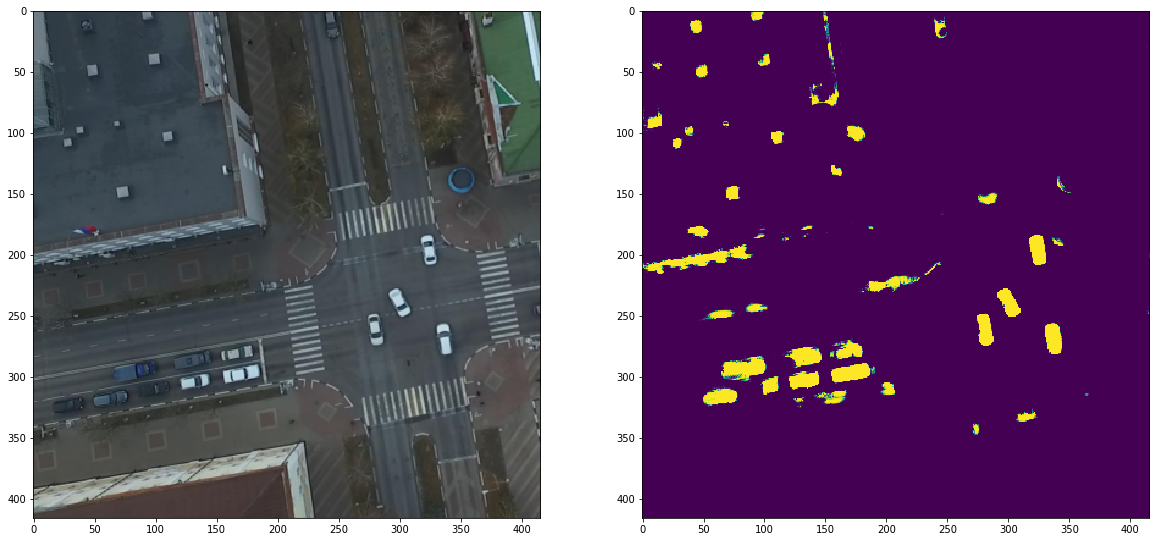

In [37]:
a,c, d=next(preview)
e=model.predict(a,steps=1)

plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(a[0,:,:])
plt.subplot(1,3,2)
plt.imshow(e[0,:,:,0])

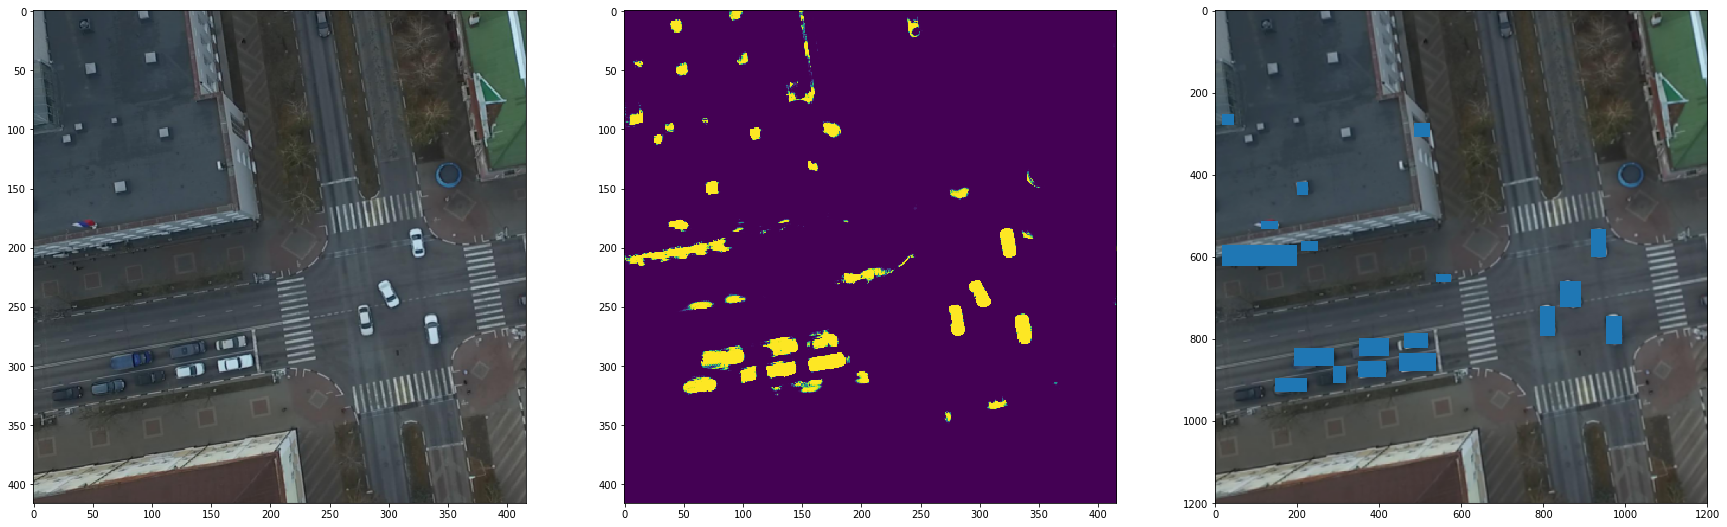

In [47]:
plt.figure(figsize=(30,10))
plt.subplot(1,3,1)
plt.imshow(a[0,:,:])
plt.subplot(1,3,2)
plt.imshow(e[0,:,:,0])
# plt.subplot(1,3,3)
ax = plt.subplot(1,3,3)
ax.imshow(resize(a[0],output_shape = c.shape[:2]))
for car in recognized_state:
    width=car[2]-car[0]
    height=car[3]-car[1]
    rect = matplotlib.patches.Rectangle(xy=(car[0],car[1]),
                                    width=width,
                                    height=height,
                                    angle=0)

    ax.add_patch(rect)

In [241]:
# a,b,c,d=next(preview)
# e=model.predict(a,steps=1)

# plt.figure(figsize=(30,10))
# plt.subplot(1,3,1)
# plt.imshow(a[0,:,:])
# plt.subplot(1,3,2)
# plt.imshow(b[0,:,:,0])
# plt.subplot(1,3,3)
# plt.imshow(e[0,:,:,0])

In [38]:
input_image = c
segmentation_result = e

In [39]:
segmentation_mask = segmentation_result[0][:,:,0]
binary_mask = ((segmentation_mask > 0.9)*255).astype('uint8')

In [40]:
maskImage = resize(binary_mask, output_shape = c.shape[:2])

In [41]:
label_image = label(maskImage)

In [42]:
area_min = 500
area_max = 6000
scale = c.shape[0]/c.shape[1]

In [43]:
recognized_state = []
for region in regionprops(label_image):
    start_y, start_x, end_y, end_x = region.bbox
    start_y = int(start_y * scale)
    start_x = int(start_x * scale)
    end_y = int(end_y * scale)
    end_x = int(end_x * scale)
    if( (region.area>area_min) and (region.area<area_max)):
        car_box = [start_x, start_y, end_x, end_y]
        recognized_state.append(car_box)

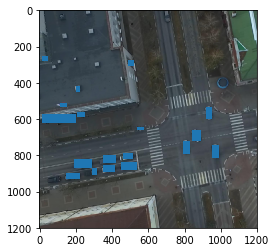

In [44]:
# plt.figure(figsize=(10,20))
fig,ax = plt.subplots(1)
ax.imshow(resize(a[0],output_shape = c.shape[:2]))
for car in recognized_state:
    width=car[2]-car[0]
    height=car[3]-car[1]
    rect = matplotlib.patches.Rectangle(xy=(car[0],car[1]),
                                    width=width,
                                    height=height,
                                    angle=0)

    ax.add_patch(rect)


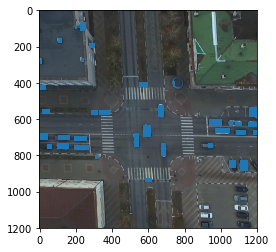

In [285]:
# plt.figure(figsize=(10,20))
fig,ax = plt.subplots(1)
ax.imshow(resize(a[0],output_shape = c.shape[:2]))
for car in recognized_state:
    width=car[2]-car[0]
    height=car[3]-car[1]
    rect = matplotlib.patches.Rectangle(xy=(car[0],car[1]),
                                    width=width,
                                    height=height,
                                    angle=0)

    ax.add_patch(rect)


NameError: name 'state' is not defined

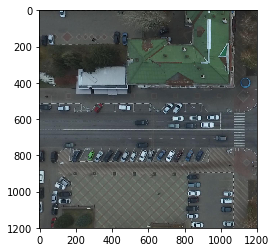

In [276]:
fig,ax = plt.subplots(1)
ax.imshow(c)
for car in state:
    width=car[2]-car[0]
    height=car[3]-car[1]
    rect = matplotlib.patches.Rectangle(xy=(car[0],car[1]),
                                    width=width,
                                    height=height,
                                    angle=0)

    ax.add_patch(rect)

In [41]:
df = pd.DataFrame(recognized_state)

In [42]:
df.to_csv(r"results/" + d[59:-3]+'txt', header=None, index=None, sep=' ', mode='a')

In [35]:
state= ([[ 713, 200 ,747 ,284],
[ 708, 388 ,749 ,492],
[ 747, 622 ,848 ,667],
[1365, 707 ,1378,742],
[ 457, 718 ,542 ,755],
[ 700, 827 ,748 ,933],
[ 638, 903 ,680 ,991],
[ 634, 1232,682,1339]])

In [95]:
f = open(d[:53]+'lables'+d[58:-3]+'txt', "r")

FileNotFoundError: [Errno 2] No such file or directory: 'D:/Library/Datasets/raai-summer-school-2019-CV-train/lables/07-02-2019-11-51-42.txt'

In [96]:
d[:53]+'lables'+d[58:-3]+'txt'

'D:/Library/Datasets/raai-summer-school-2019-CV-train/lables/07-02-2019-11-51-42.txt'

In [97]:
D:/Library/Datasets/raai-summer-school-2019-CV-train/labels/07-02-2019-11-51-42.txt

'D:/Library/Datasets/raai-summer-school-2019-CV-train/color/07-02-2019-11-51-42.jpg'